In [ ]:
# The following libraries will let you use opencv
import cv2 #opencv itself
import numpy as np # matrix manipulations
import pandas as pd # dataframes
import os
#the following are to do with this interactive notebook code
%matplotlib inline 
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from joblib import dump, load

In [ ]:
def proportions(photo, scaleFactor=1.1, minNeighbors=5):
    # Convert the photo to grey for better detection
    person_grey = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)
    # Convert back to RGB for displaying later
    photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)
    # Load the pre-trained classifiers for face, smile, and eyes
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(person_grey, scaleFactor=scaleFactor, minNeighbors=minNeighbors)
    n = 0
    # Create a dataframe to store the results
    data = pd.DataFrame(columns=['Face', 'Face_x', 'Face_y', 'Face_w', 'Face_h', 'Smile_x', 'Smile_y', 'Smile_w', 'Smile_h', 'Eye1_x', 'Eye1_y', 'Eye1_w', 'Eye1_h', 'Eye2_x', 'Eye2_y', 'Eye2_w', 'Eye2_h'])
    for (x, y, w, h) in faces:
        # Find the detected faces
        n += 1
        data.loc[n, 'Face'] = n
        # For each face, detect smiles and eyes within the face region
        smile = smile_cascade.detectMultiScale(person_grey[y:(y+h), x:(x+w)], scaleFactor=scaleFactor, minNeighbors=minNeighbors)
        data.loc[n, ['Face_x', 'Face_y', 'Face_w', 'Face_h']] = [x, y, w, h]
        for (xs, ys, ws, hs) in smile:
            # Save the first data from the first detected smile
            data.loc[n, ['Smile_x', 'Smile_y', 'Smile_w', 'Smile_h']] = [x+xs, y+ys, ws, hs]
        eye = eye_cascade.detectMultiScale(person_grey[y:(y+h), x:(x+w)], scaleFactor=scaleFactor, minNeighbors=minNeighbors)
        for (xe, ye, we, he) in eye:
            if pd.isna(data.loc[n, 'Eye1_x']):
                data.loc[n, ['Eye1_x', 'Eye1_y', 'Eye1_w', 'Eye1_h']] = [x+xe, y+ye, we, he]
            elif pd.isna(data.loc[n, 'Eye2_x']):
                data.loc[n, ['Eye2_x', 'Eye2_y', 'Eye2_w', 'Eye2_h']] = [x+xe, y+ye, we, he]
    return(data)

In [135]:
def proportions_processing(data):
    # Specify tne new columns to be created
    required_columns = ['Smile_w_prop', 'Eye1_w_prop', 'Eye2_w_prop', 'Smile_h_prop', 'Eye1_h_prop', 'Eye2_h_prop', 'forehead_prop', 'nose_prop', 'chin_prop', 'Eyes_y', 'Eyes_mid_y']

    # Subtle differences in handling for dataframes vs series
    if type(data) == pd.DataFrame:
        # Check for missing columns and add them with NaN values if they are missing
        missing_columns = [col for col in required_columns if col not in data.columns]
        for col in missing_columns:
            data[col] = np.nan

        # Calculate the proportional measurements and add them to the dataframe
        data[['Smile_w_prop', 'Eye1_w_prop', 'Eye2_w_prop']] = data[['Smile_w', 'Eye1_w', 'Eye2_w']].div(data['Face_w'], axis=0)
        data[['Smile_h_prop', 'Eye1_h_prop', 'Eye2_h_prop']] = data[['Smile_h', 'Eye1_h', 'Eye2_h']].div(data['Face_h'], axis=0)
        data['Eyes_y'] = np.mean([data['Eye1_y'], data['Eye2_y']], axis=0)
        data['Eyes_mid_y'] = np.mean([data['Eye1_y']+0.5*data['Eye1_h'], data['Eye2_y']+0.5*data['Eye2_h']], axis=0)
        data['forehead_prop'] = (((data['Eyes_y']-(data['Face_y']))/data['Face_h']).iloc[0])
        data['nose_prop'] = ((((data['Smile_y'])-data['Eyes_mid_y'])/data['Face_h']).iloc[0])
    else:
        missing_columns = [col for col in required_columns if col not in data.index]
        for col in missing_columns:
            data[col] = np.nan

        data[['Smile_w_prop', 'Eye1_w_prop', 'Eye2_w_prop']] = data[['Smile_w', 'Eye1_w', 'Eye2_w']].div(data['Face_w'], axis=0)
        data[['Smile_h_prop', 'Eye1_h_prop', 'Eye2_h_prop']] = data[['Smile_h', 'Eye1_h', 'Eye2_h']].div(data['Face_h'], axis=0)
        data['Eyes_y'] = np.mean([data['Eye1_y'], data['Eye2_y']], axis=0)
        data['Eyes_mid_y'] = np.mean([data['Eye1_y']+0.5*data['Eye1_h'], data['Eye2_y']+0.5*data['Eye2_h']], axis=0)
        data['forehead_prop'] = (((data['Eyes_y']-(data['Face_y']))/data['Face_h']))
        data['nose_prop'] = ((((data['Smile_y'])-data['Eyes_mid_y'])/data['Face_h']))
    return(data)

In [ ]:
def proportions_overlay(photo, data, facecolor =(255,0,0), eyecolor =(0,255,0), smilecolor =(0,0,255), thickness=2, textsize=1):
    # Convert back to RGB for displaying later
    photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)

    # Check if there is data to process
    try:
        data = dict(data.iloc[0])
    except:
        print("No face detected")
        return
    
    # Add text labels for Face, Smile, and Eyes in the correct colours
    cv2.putText(photo,'Face', (0,15), cv2.FONT_HERSHEY_PLAIN, 1, facecolor, 1)
    cv2.putText(photo,'Smile', (0,30), cv2.FONT_HERSHEY_PLAIN, 1, smilecolor, 1)
    cv2.putText(photo,'Eyes', (0,50), cv2.FONT_HERSHEY_PLAIN, 1, eyecolor, 1)

    # Draw rectangles around the detected features and add proportional measurements
    for i in ['Face', 'Smile', 'Eye1', 'Eye2']:
        if pd.isna(data[f'{i}_x']):
            continue
        x, y, w, h= int(data[f'{i}_x']), int(data[f'{i}_y']), int(data[f'{i}_w']), int(data[f'{i}_h'])
        color = facecolor if i == 'Face' else smilecolor if i == 'Smile' else eyecolor
        cv2.rectangle(photo, (x, y), (x+w, y+h), color, thickness)
        if i != 'Face':
            w_prop, h_prop = round((data[f'{i}_w_prop']),1), round((data[f'{i}_h_prop']),1)
            cv2.putText(photo, str(h_prop), (x,y-5), cv2.FONT_HERSHEY_PLAIN, textsize, color, 1)
            if w_prop != h_prop:
                cv2.putText(photo, str(w_prop), (x-20,y+10), cv2.FONT_HERSHEY_PLAIN, textsize, color, 1)

    # Draw horizontal lines for forehead, nose, and chin proportions
    for i in ['forehead_prop', 'nose_prop', 'chin_prop']:
        if pd.isna(data[i]):
            continue
        prop = round(data[i], 2)
        y = int(data['Face_y'] + prop * data['Face_h']) if i == 'forehead_prop' else int(data['Eyes_mid_y'] + prop * data['Face_h']) if i == 'nose_prop' else int(data['Face_y'] + data['Face_h'] - prop * data['Face_h'])
        cv2.line(photo, (data['Face_x'], y), (data['Face_x']+data['Face_w'], y), (255,255,0), 1)
        cv2.putText(photo, str(prop), (data['Face_x']+data['Face_w']+5,y-10), cv2.FONT_HERSHEY_PLAIN, textsize, (255,255,0), 1)

    return plt.imshow(photo)

In [ ]:
#Initialise a dataframe to hold the results
control_data = pd.DataFrame()
control = 0
# For each file in the control folder locate the proportions
for files in os.listdir('.\data\control'):
    if files.endswith('.jpg') or files.endswith('.png') or files.endswith('.jpeg'):
        control += 1
        print(f"Processing {files}")
        img = cv2.imread(os.path.join('.\data\control', files))
        data = proportions(img, 1.1, 5)
        data['Image'] = files
        control_data = pd.concat([control_data, data], ignore_index=True)

Processing 0.jpg
Processing 002.jpg
Processing 004.jpg
Processing 0052.jpg
Processing 0058.jpg
Processing 0094.jpg
Processing 0098.jpg
Processing 0179.jpg
Processing 0184.jpg
Processing 0188.jpg
Processing 0212.jpg
Processing 0223.jpg
Processing 0280.jpg
Processing 0287.jpg
Processing 0292.jpg
Processing 0305.jpg
Processing 0354.jpg
Processing 0356.jpg
Processing 0359.jpg
Processing 0376.jpg
Processing 0377.jpg
Processing 0381.jpg
Processing 0398.jpg
Processing 0405.jpg
Processing 0438.jpg
Processing 0583.jpg
Processing 0590.jpg
Processing 0593.jpg
Processing 0596.jpg
Processing 0618.jpg
Processing 0647.jpg
Processing 0666.jpg
Processing 0721.jpg
Processing 0722.jpg
Processing 0734.jpg
Processing 0736.jpg
Processing 0739.jpg
Processing 0748.jpg
Processing 0805.jpg
Processing 0810.jpg
Processing 0815.jpg
Processing 0820.jpg
Processing 0891.jpg
Processing 0904.jpg
Processing 0921.jpg
Processing 1.jpg
Processing 10.jpg
Processing 100.jpg
Processing 101.jpg
Processing 102.jpg
Processing 10

In [ ]:
noncontrol_data = pd.DataFrame()
noncontrol = 0
# For each file in the downSyndrome folder locate the proportions
for files in os.listdir('.\data\downSyndrome'):
    if files.endswith('.jpg') or files.endswith('.png') or files.endswith('.jpeg'):
        noncontrol += 1
        print(f"Processing {files}")
        img = cv2.imread(os.path.join('.\data\downSyndrome', files))
        data = proportions(img, 1.1, 5)
        data['Image'] = files
        noncontrol_data = pd.concat([noncontrol_data, data], ignore_index=True)

Processing down_1.jpg
Processing down_10.jpg
Processing down_100.jpg
Processing down_1000.jpg
Processing down_1001.jpg
Processing down_1002.jpg
Processing down_1003.jpg
Processing down_1004.jpg
Processing down_1005.jpg
Processing down_1006.jpg
Processing down_1007.jpg
Processing down_1008.jpg
Processing down_1009.jpg
Processing down_101.jpg
Processing down_1010.jpg
Processing down_1011.jpg
Processing down_1012.jpg
Processing down_1013.jpg
Processing down_1014.jpg
Processing down_1015.jpg
Processing down_1016.jpg
Processing down_1017.jpg
Processing down_1018.jpg
Processing down_1019.jpg
Processing down_102.jpg
Processing down_1020.jpg
Processing down_1021.jpg
Processing down_1022.jpg
Processing down_1023.jpg
Processing down_1024.jpg
Processing down_1025.jpg
Processing down_1026.jpg
Processing down_1027.jpg
Processing down_1028.jpg
Processing down_1029.jpg
Processing down_103.jpg
Processing down_1030.jpg
Processing down_1031.jpg
Processing down_1032.jpg
Processing down_1033.jpg
Processin

In [ ]:
# Specify the classification
control_data['Classification'] = 'Control'
noncontrol_data['Classification'] = 'DownSyndrome'

# Combine both sets of data
all_data = pd.concat([control_data, noncontrol_data], ignore_index=True)

# Save to csv to save processing time in future
all_data.to_csv('all_data_raw.csv', index=False)

# Check for missing values in the dataset
all_data.isnull().sum()

Face                0
Face_x              0
Face_y              0
Face_w              0
Face_h              0
Smile_x           233
Smile_y           233
Smile_w           233
Smile_h           233
Eye1_x            200
Eye1_y            200
Eye1_w            200
Eye1_h            200
Eye2_x            366
Eye2_y            366
Eye2_w            366
Eye2_h            366
Image               0
Classification      0
dtype: int64

In [ ]:
# Read in the data
all_data = pd.read_csv('all_data_raw.csv')
# Apply the processing to each row of the data
data_processed = all_data.apply(proportions_processing, axis=1)
# Remove NA values ahead of machine learning
data_processed = data_processed.dropna()

data_processed

,Face,Face_x,Face_y,Face_w,Face_h,Smile_x,Smile_y,Smile_w,Smile_h,Eye1_x,...,Eye1_w_prop,Eye2_w_prop,Smile_h_prop,Eye1_h_prop,Eye2_h_prop,forehead_prop,nose_prop,chin_prop,Eyes_y,Eyes_mid_y
1,1,20,112,218,218,26.0,182.0,120.0,60.0,57.0,...,0.293578,0.243119,0.275229,0.293578,0.243119,0.252294,-0.065367,0.678899,167.0,196.25
2,1,16,44,239,239,82.0,95.0,132.0,66.0,62.0,...,0.246862,0.092050,0.276151,0.246862,0.092050,0.420502,-0.291841,0.786611,144.5,164.75
3,1,31,21,364,364,256.0,111.0,94.0,47.0,163.0,...,0.162088,0.131868,0.129121,0.162088,0.131868,0.570055,-0.396291,0.752747,228.5,255.25
4,1,26,127,250,250,80.0,283.0,142.0,71.0,162.0,...,0.252000,0.280000,0.284000,0.252000,0.280000,0.250000,0.241000,0.376000,189.5,222.75
6,1,24,46,184,184,64.0,174.0,113.0,56.0,94.0,...,0.114130,0.331522,0.304348,0.114130,0.331522,0.456522,0.127717,0.304348,130.0,150.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424,1,99,94,390,390,210.0,392.0,176.0,88.0,249.0,...,0.058974,0.105128,0.225641,0.058974,0.105128,0.597436,0.125641,0.235897,327.0,343.00
1425,1,35,66,107,107,73.0,146.0,45.0,23.0,92.0,...,0.233645,0.214953,0.214953,0.233645,0.214953,0.285047,0.350467,0.252336,96.5,108.50
1426,1,79,123,156,156,103.0,154.0,111.0,55.0,177.0,...,0.179487,0.307692,0.352564,0.179487,0.307692,0.256410,-0.179487,0.801282,163.0,182.00
1428,1,45,60,124,124,75.0,138.0,67.0,34.0,114.0,...,0.241935,0.258065,0.274194,0.241935,0.258065,0.266129,0.237903,0.370968,93.0,108.50


In [ ]:
# Print the number of original samples
print(control)
print(noncontrol)

572
1500


In [ ]:
# Print the number of samples after processing
data_processed['Classification'].value_counts()

Classification
DownSyndrome    802
Control         173
Name: count, dtype: int64

In [ ]:
# Select the features and the target variable for classification
classification_features = data_processed[['Smile_w_prop', 'Smile_h_prop', 'Eye1_w_prop', 'Eye2_w_prop', 'forehead_prop', 'nose_prop']]

classification_target = data_processed['Classification']

In [ ]:
# Create a train test split for hyperparameter tuning
train_features, test_features, train_target, test_target = train_test_split(classification_features, classification_target, test_size=0.2, random_state=1, stratify= classification_target)

In [ ]:
# Check the dimensions of each
print(train_features.shape)
print(test_features.shape)
print(train_target.shape)
print(test_target.shape)

(780, 6)
(195, 6)
(780,)
(195,)


In [ ]:
# Test the number of neighbours
for neighbours in range(1, 11):
    print(neighbours)
    knn = KNeighborsClassifier(n_neighbors=neighbours)

    knn.fit(train_features, train_target)

    print(knn.score(test_features, test_target))

1
0.8307692307692308
2
0.7333333333333333
3
0.841025641025641
4
0.8102564102564103
5
0.8615384615384616
6
0.8615384615384616
7
0.8666666666666667
8
0.8717948717948718
9
0.8564102564102564
10
0.8615384615384616


In [ ]:
# Use the best accuracy neighbours to train the model
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(train_features, train_target)

prediction = knn.predict(test_features)

In [ ]:
# Find overall accuracy statistics
accuracy = knn.score(test_features, test_target)

def precision(actual, predicted, positive='DownSyndrome'):
    TP = np.sum((actual == positive) & (predicted == positive))
    TN = np.sum((actual != positive) & (predicted != positive))
    FP = np.sum((actual != positive) & (predicted == positive))
    FN = np.sum((actual == positive) & (predicted != positive))
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    output = f"Precision: {precision*100:.1f}% (TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN})"
    return(output)

print(precision(test_target, prediction, positive='DownSyndrome'))
print(precision(test_target, prediction, positive='Control'))
print(f"Overall accuracy: {accuracy*100:.1f}%")

Precision: 87.6% (TP: 155, TN: 13, FP: 22, FN: 5)
Precision: 72.2% (TP: 13, TN: 155, FP: 5, FN: 22)
Overall accuracy: 86.2%


In [ ]:
# Test the max depth of the tree
for depth in range(1, 11):
    print(depth)
    tree = DecisionTreeClassifier(max_depth=depth)

    tree.fit(train_features, train_target)

    print(tree.score(test_features, test_target))

1
0.8205128205128205
2
0.8615384615384616
3
0.841025641025641
4
0.841025641025641
5
0.8205128205128205
6
0.8102564102564103
7
0.8102564102564103
8
0.8102564102564103
9
0.8256410256410256
10
0.8051282051282052


In [ ]:
# Use the best accuracy depth to train the model
tree = DecisionTreeClassifier(max_depth=3)

tree.fit(classification_features, classification_target)

prediction = tree.predict(classification_features)

In [ ]:
# Find overall accuracy statistics
accuracy = tree.score(classification_features, classification_target)

print(precision(classification_target, prediction, positive='DownSyndrome'))
print(precision(classification_target, prediction, positive='Control'))
print(f"Overall accuracy: {accuracy*100:.1f}%")

Precision: 87.8% (TP: 750, TN: 69, FP: 104, FN: 52)
Precision: 57.0% (TP: 69, TN: 750, FP: 52, FN: 104)
Overall accuracy: 84.0%


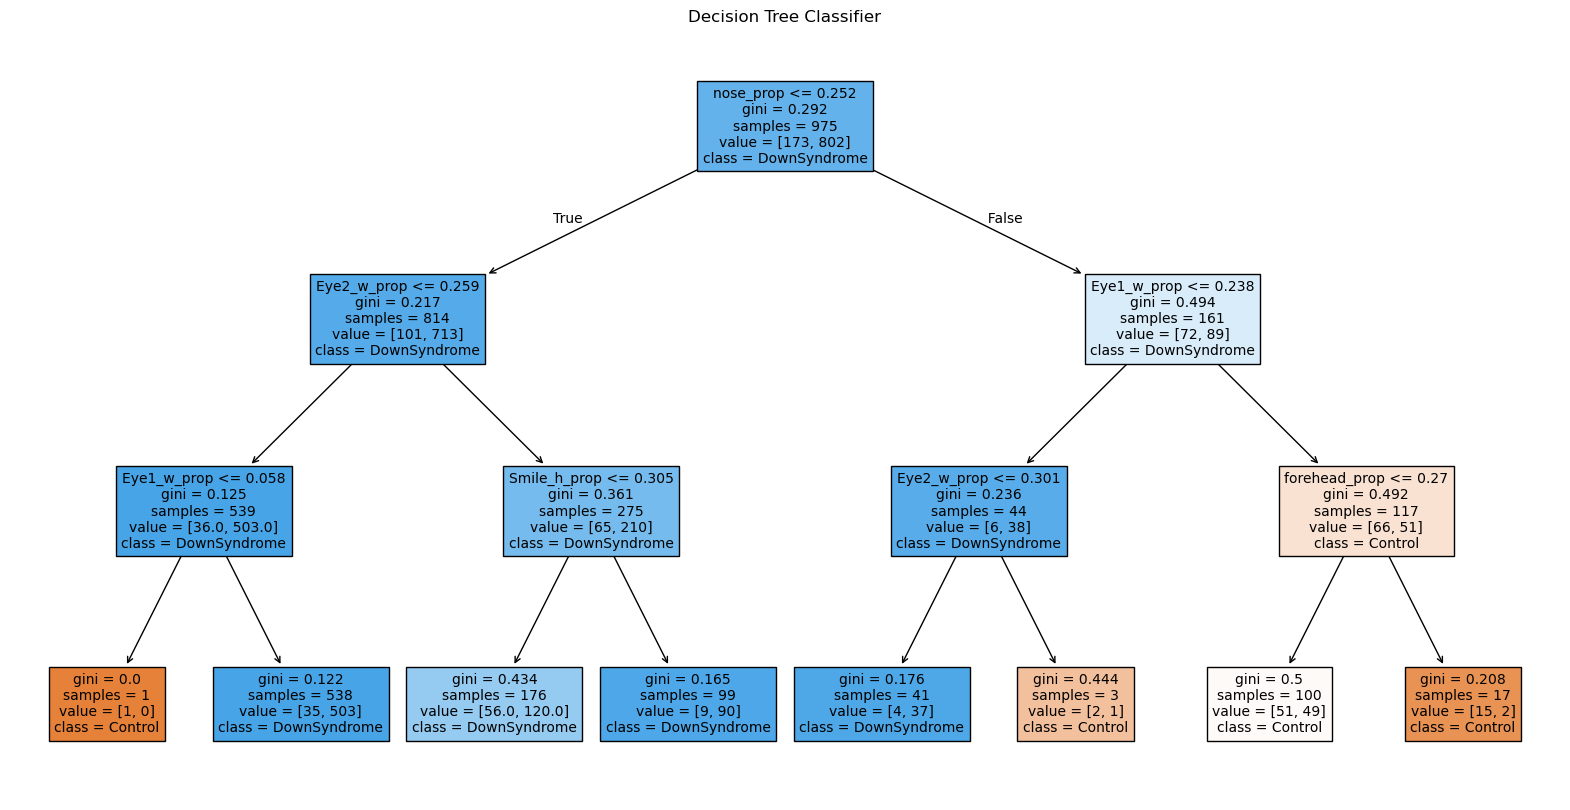

In [49]:
# Create a tree plot for the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree,
          feature_names=classification_features.columns,
          # Use the class names from the classification target to colour the diagram
          class_names = classification_target.unique(),
          filled=True, fontsize=10)
plt.title(f'Decision Tree Classifier')
plt.show()

In [ ]:
# Save down the KNN model
dump(knn, 'knn.joblib')

In [ ]:
# Load the model
knn_load = load('knn.joblib')

In [139]:
# Check the detection of the model on a new image
def check_detection(file, textsize=1):
    photo = cv2.imread(file)
    data = proportions(photo, 1.1, 5)
    if data.empty:
        print("No face detected")
        plt.imshow(cv2.cvtColor(photo, cv2.COLOR_BGR2RGB))
        return
    data = proportions_processing(data)
    prediction = knn_load.predict(data[['Smile_w_prop', 'Smile_h_prop', 'Eye1_w_prop', 'Eye2_w_prop', 'forehead_prop', 'nose_prop']])
    print("This sample as been classified as:", prediction[0])
    proportions_overlay(photo, data, textsize=textsize)
    plt.show()

This sample as been classified as: Control


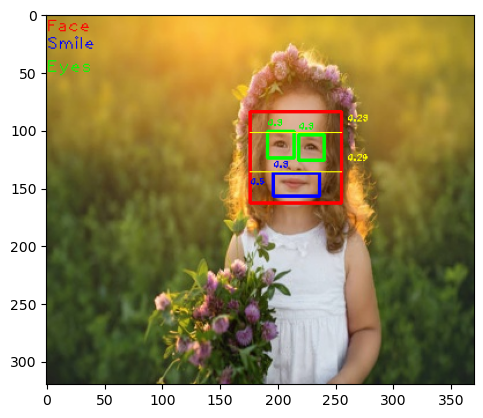

In [136]:
file = 'data/control/87.jpg'
check_detection(file, 0.5)

This sample as been classified as: DownSyndrome


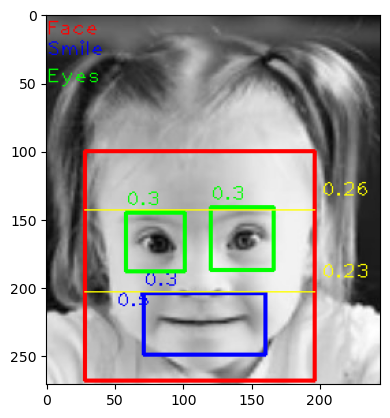

In [137]:
file = 'data/DownSyndrome/down_1432.jpg'
check_detection(file, 1)

No face detected


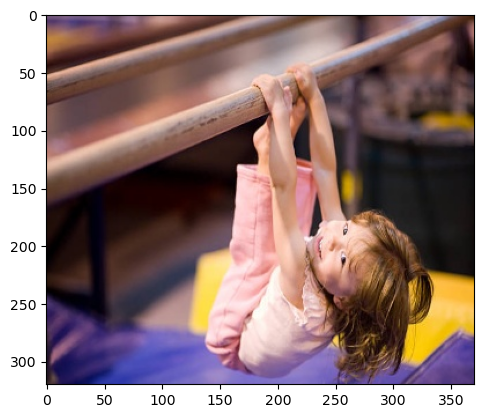

In [140]:
file = 'data/control/2.jpg'
check_detection(file, 0.5)